## Code to produce rain rate and DSD products for D3R Ku band.

In [2]:
import xarray as xr
import requests, os
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyart
import math
import numpy as np
from PIL import Image
from IPython.display import display

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain,
                            csu_dsd, csu_kdp, csu_misc, fundamentals)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Choose Wallops or Paper ifloods data
### Load Wallops D3R CF data

In [ ]:
# Download and read file
dtype = 'Wallops'
response = requests.get('https://pmm-gv.gsfc.nasa.gov/pub/NPOL/temp/D3R/KuD3R_20240415_232744_PPI.cf')
open("./KuD3R_20240415_232744_PPI.cf", "wb").write(response.content)

file = "./KuD3R_20240415_232744_PPI.cf"

#file = "/Users/jpippitt/GPM-GV/D3R/KuD3R_20240415_232744_PPI.cf"
radar = pyart.io.read(file, file_field_names=True)
print(radar.fields.keys())
os.remove(file)

### Load D3R data from IFloods test case.

In [3]:
# Download and read file
dtype = 'ifloods'
response = requests.get('https://pmm-gv.gsfc.nasa.gov/pub/NPOL/temp/D3R/ifloods_d3r_ku_20130529_224831.cf')
open("./ifloods_d3r_ku_20130529_224831.cf", "wb").write(response.content)

file = "./ifloods_d3r_ku_20130529_224831.cf"

#file = '/Users/jpippitt/GPM-GV/D3R/ifloods/ppi/ifloods_d3r_ku_20130529_224831.cf'
radar = pyart.io.read(file, file_field_names=True)
print(radar.fields.keys())
os.remove(file)

dict_keys(['Reflectivity', 'Velocity', 'SpectralWidth', 'DifferentialReflectivity', 'DifferentialPhase', 'CrossPolCorrelation', 'NormalizedCoherentPower', 'SpecificPhase'])


### Plot DZ, ZDR, rhoHV

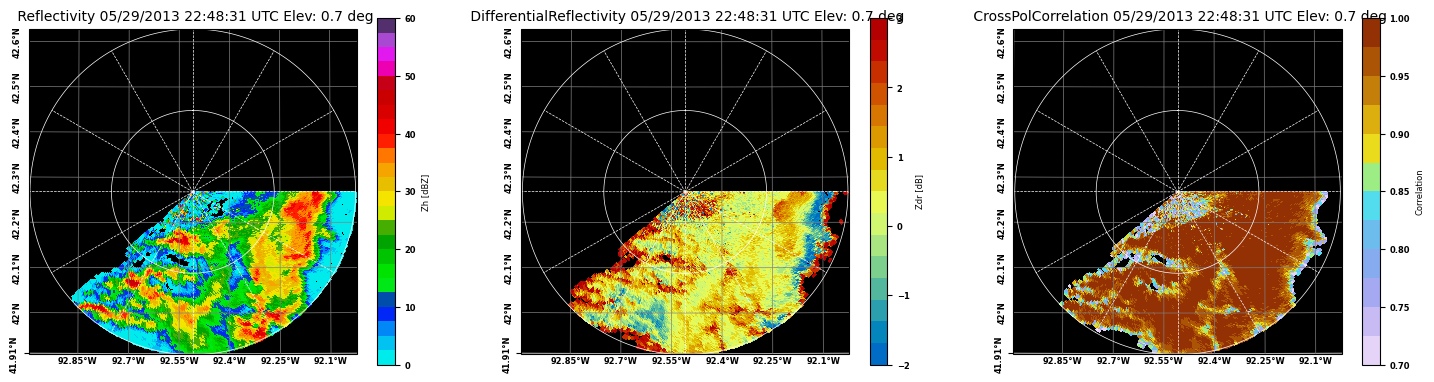

In [4]:
# Set plotting range
lim = [-40, 40]

# Set plotting min, max.
if dtype == 'Wallops': 
    vmin2=-4
    vmax2=2
if dtype == 'ifloods':
    vmin2=-2
    vmax2=3

if dtype == 'Wallops': rhoHV = 'CopolarCorrelation'
if dtype == 'ifloods': rhoHV = 'CrossPolCorrelation'

three_panel_plot(radar, sweep=0,
                 var1='Reflectivity', vmin1=0, vmax1=60, cmap1=discrete_cmap(24,'pyart_NWSRef'), units1='Zh [dBZ]',
                 var2='DifferentialReflectivity', vmin2=vmin2, vmax2=vmax2, cmap2=discrete_cmap(16,'pyart_HomeyerRainbow'), units2='Zdr [dB]',
                 var3=rhoHV, vmin3=0.70, vmax3=1.0, cmap3=discrete_cmap(12,'pyart_LangRainbow12'), units3='Correlation',
                 xlim=lim, ylim=lim)

### ZDR is cold for Wallops dataset, add offset.

In [ ]:
# Set ZDR offset
zdr_cal = (-2.0)
fill_value = -32767.0

# Calibrate ZDR field
zdr_field = radar.fields['DifferentialReflectivity']['data'].copy()
corr_zdr = pyart.correct.correct_bias(radar, bias=zdr_cal, field_name='DifferentialReflectivity')

# Add Calibrated ZDR field
corzdr_dict = {'data': corr_zdr['data'], 'units': '', 'long_name': 'DifferentialReflectivity',
               '_FillValue': fill_value, 'standard_name': 'DifferentialReflectivity'}
radar.add_field('DifferentialReflectivity', corzdr_dict, replace_existing=True)

### Plot new ZDR field

In [ ]:
three_panel_plot(radar, sweep=0,
                 var1='Reflectivity', vmin1=0, vmax1=60, cmap1=discrete_cmap(24,'pyart_NWSRef'), units1='Zh [dBZ]',
                 var2='DifferentialReflectivity', vmin2=-2, vmax2=3, cmap2=discrete_cmap(16,'pyart_HomeyerRainbow'), units2='Zdr [dB]',
                 var3='CopolarCorrelation', vmin3=0.70, vmax3=1.0, cmap3=discrete_cmap(12,'pyart_LangRainbow12'), units3='Correlation',
                 xlim=lim, ylim=lim)

### Get Bringi KDP from CSU radar tools

In [5]:
# Get Bringi KDP
DZ = extract_unmasked_data(radar, 'Reflectivity')
DP = extract_unmasked_data(radar, 'DifferentialPhase')
rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])
gate_spacing = radar.range['meters_between_gates']  
window=4

KDPB, PHIDPB, STDPHIB = csu_kdp.calc_kdp_bringi(dp=DP, dz=DZ, rng=rng2d/1000.0, 
                                                thsd=25, gs=gate_spacing, 
                                                window=window, nfilter=1, std_gate=15)

radar = add_field_to_radar_object(KDPB, radar, field_name='KD', 
                                  units='deg/km',
                                  long_name='Specific Differential Phase (Bringi)',
                                  standard_name='Specific Differential Phase (Bringi)',
                                  dz_field='Reflectivity')

### Retrieve rain rate based on:
H. Chen and V. Chandrasekar, "Estimation of Light Rainfall Using Ku-Band Dual-Polarization Radar."

In [6]:
kd = radar.fields['KD']['data']
dz = radar.fields['Reflectivity']['data']
dr = radar.fields['DifferentialReflectivity']['data']
ZhL = linearize(dz)
drL = linearize(dr)

# KDP rain rate
R = power_law(kd, 10.43, 0.88)

# ZDR Zh rain rate
RZHKD = 7 * power_law(dz,0.001,0.95) * power_law(drL,1,-4.94)

# ZDR KDP rain rate
RDRKD = power_law(drL,18.01,-1.28) * power_law(kd,1,0.95)

rr_dict = {"data": R, "units": "mm/h",
           "long_name": "Ku KDP Rainfall Rate", "_FillValue": 0.0,
           "standard_name": "Ku KDP Rainfall Rate",}
radar.add_field("RR", rr_dict, replace_existing=True)

rzd_dict = {"data": RZHKD, "units": "mm/h",
           "long_name": "Ku ZH/KDP Rainfall Rate", "_FillValue": 0.0,
           "standard_name": "Ku ZH/KDP Rainfall Rate",}
radar.add_field("RH", rzd_dict, replace_existing=True)

rdk_dict = {"data": RDRKD, "units": "mm/h",
           "long_name": "Ku ZDR/KDP Rainfall Rate", "_FillValue": 0.0,
           "standard_name": "Ku ZDR/KDP Rainfall Rate",}
radar.add_field("RD", rdk_dict, replace_existing=True)

### Plot phiDP, KDP, rain rate

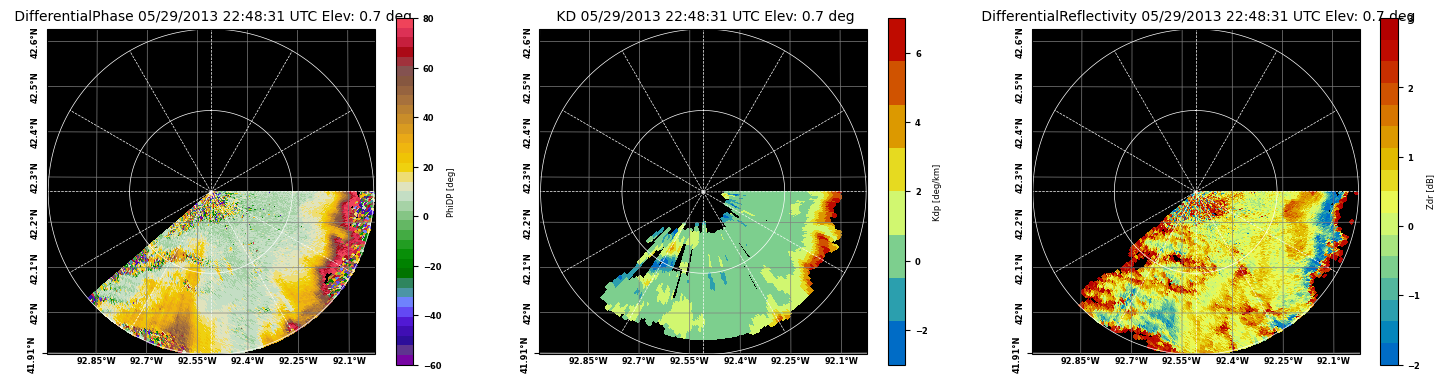

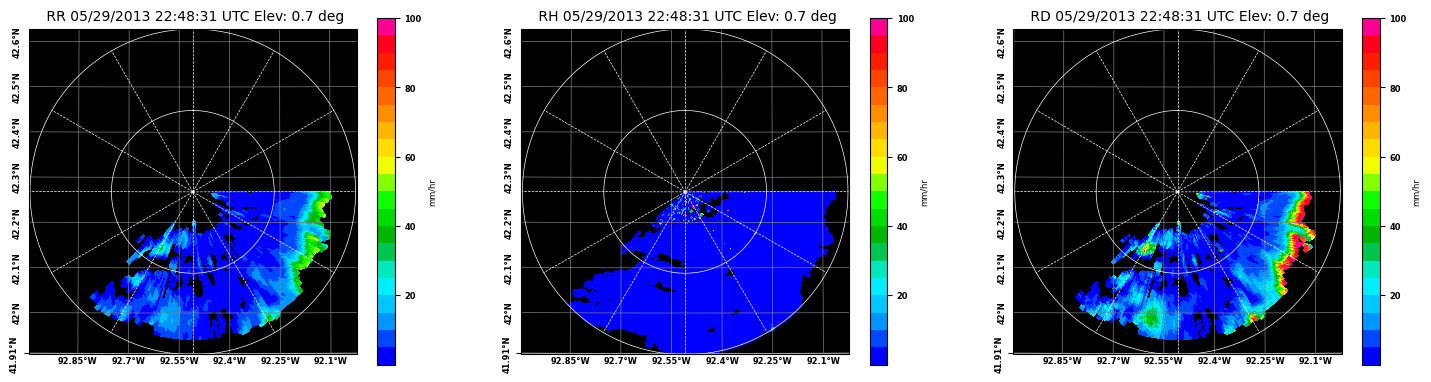

In [9]:
# Set plotting min, max.
if dtype == 'Wallops': 
    vmin1=-140
    vmax1=-40
    vmin2=-2
    vmax2=5
if dtype == 'ifloods':
    vmin1=-60
    vmax1=80
    vmin2=-3
    vmax2=7
vmin3=-2
vmax3=3

three_panel_plot(radar, sweep=0,
                 var1='DifferentialPhase', vmin1=vmin1, vmax1=vmax1, cmap1=discrete_cmap(36,'pyart_Carbone42'), units1='PhiDP [deg]',
                 var2='KD', vmin2=vmin2, vmax2=vmax2, cmap2=discrete_cmap(8,'pyart_HomeyerRainbow'), units2='Kdp [deg/km]',
                 var3='DifferentialReflectivity', vmin3=vmin3, vmax3=vmax3, cmap3=discrete_cmap(16,'pyart_HomeyerRainbow'), units3='Zdr [dB]',
                 xlim=lim, ylim=lim)

three_panel_plot(radar, sweep=0,
                 var1='RR', vmin1=1e-2, vmax1=1e2, cmap1=discrete_cmap(20,'pyart_RefDiff'), units1='mm/hr',
                 var2='RH', vmin2=1e-2, vmax2=1e2, cmap2=discrete_cmap(20,'pyart_RefDiff'), units2='mm/hr',
                 var3='RD', vmin3=1e-2, vmax3=1e2, cmap3=discrete_cmap(20,'pyart_RefDiff'), units3='mm/hr',
                 xlim=lim, ylim=lim)

### Retrieve D0 and NW based on:
H. Chen and V. Chandrasekar, "Estimation of rainfall drop size distribution from dual-polarization measurements at S-band, X-band, and Ku-band radar frequencies." 
Gorgucci, E., V. Chandrasekar, V. N. Bringi, and G. Scarchilli, "Estimation of Raindrop Size Distribution Parameters from Polarimetric Radar Measurements."

In [10]:
dz = radar.fields['Reflectivity']['data']
dr = radar.fields['DifferentialReflectivity']['data']

# Linearize DZ and ZDR
ZhL = linearize(dz)    
drL = linearize(dr)

# Constants from Gorgucci at el. These coefficients are (valid for S band)
a1 = 0.56
b1 = 0.064
b2 = 0.076

# Calculate Beta, a2, and c2; from Chen at el.
b = power_law((kd/ZhL),0.632,0.276) * power_law(1.212,1,drL)
a2 = power_law(b, 0.14, -0.34)
c2 = power_law(b, 0.097, -0.97)

# Calculate D0 and NW from Chen at el.
D0 = power_law(((drL - 0.8)/b),a1,b1)
nw = power_law(ZhL,a2,b2) * power_law(((drL - 0.8)/b),1,c2)
NW = np.log10(nw)

# Add fields to radar structure
d0_dict = {"data": D0, "units": "D0 [mm]",
           "long_name": "Drop Median Diameter", "_FillValue": 0.0,
           "standard_name": "Drop Median Diameter",}
radar.add_field("D0", d0_dict, replace_existing=True)
    
nw_dict = {"data": NW, "units": "Log[Nw, m^-3 mm^-1]",
           "long_name": "Normalized intercept parameter", "_FillValue": 0.0,
           "standard_name": "Normalized intercept parameter",}
radar.add_field("NW", nw_dict, replace_existing=True)

### Plot DZ, D0, NW

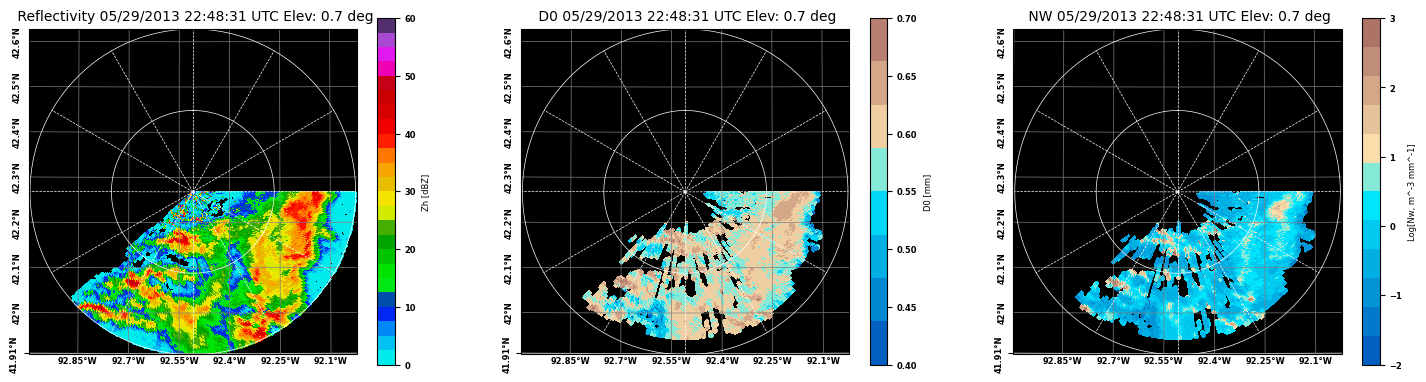

In [11]:
# Set plotting min, max.
if dtype == 'Wallops': 
    vmin2=0.3
    vmax2=0.7
    vmin3=-2.5
    vmax3=3.0
if dtype == 'ifloods':
    vmin2=0.4
    vmax2=0.7
    vmin3=-2.0
    vmax3=3.0

three_panel_plot(radar, sweep=0,
                 var1='Reflectivity', vmin1=0, vmax1=60, cmap1=discrete_cmap(24,'pyart_NWSRef'), units1='Zh [dBZ]',
                 var2='D0', vmin2=vmin2, vmax2=vmax2, cmap2=discrete_cmap(8,'pyart_BlueBrown10'), units2='D0 [mm]',
                 var3='NW', vmin3=vmin3, vmax3=vmax3, cmap3=discrete_cmap(12,'pyart_BlueBrown10'), units3='Log[Nw, m^-3 mm^-1]',
                 xlim=lim, ylim=lim)

### Grid for data analysis.

In [12]:
def compute_number_of_points(extent, resolution):
    return int((extent[1] - extent[0])/resolution)

z_grid_limits = (0.,2_000.)
y_grid_limits = (-100_000.,100_000.)
x_grid_limits = (-100_000.,100_000.)

grid_resolution = 500

z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)

grid = pyart.map.grid_from_radars(
           radar,
           grid_shape=(10,
                       301,
                       301),
           grid_limits=(z_grid_limits,
                        y_grid_limits,
                        x_grid_limits),)
    
xradar = grid.to_xarray()

### View histogram from paper and plot from above data for D0 and NW

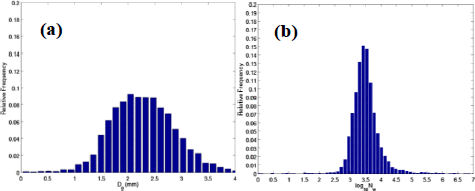

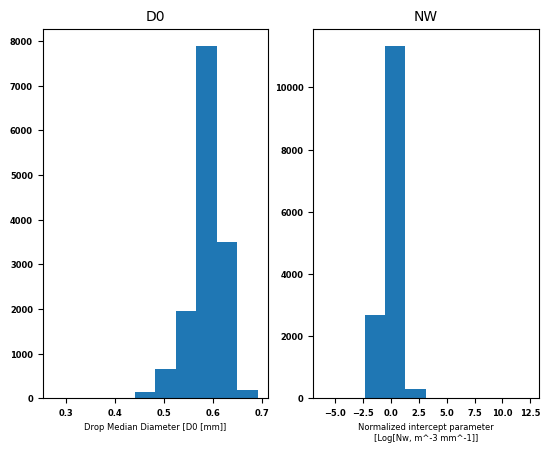

In [13]:
fig, (ax0,ax1) = plt.subplots(ncols=2)
xr.plot.hist(xradar['D0'],ax=ax0)
xr.plot.hist(xradar['NW'],ax=ax1)
ax0.set_title('D0')
ax1.set_title('NW')
img = Image.open("/Users/jpippitt/GPM-GV/D3R/6947613-fig-7-source-large.gif")
display(img)

### Plotting and Addtional Functions

In [1]:
def three_panel_plot(radar, sweep=0, var1='reflectivity', title1 = ' ', vmin1=0, vmax1=65,
                     cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity', title2 = ' ',
                     vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                     xlim=[-150,150], ylim=[-150,150], var3='reflectivity', title3 = ' ', vmin3=0, vmax3=65,
                     cmap3='RdYlBu_r', units3='dBZ', ):
    
    site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep = get_radar_info(radar, sweep)
    title1 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var1,mydate,mytime,elv)
    title2 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var2,mydate,mytime,elv)
    title3 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var3,mydate,mytime,elv)
    
    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = xlim[1] * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))

    min_lat = radar_lat - maxrange_meters * meters_to_lat
    max_lat = radar_lat + maxrange_meters * meters_to_lat
    min_lon = radar_lon - maxrange_meters * meters_to_lon
    max_lon = radar_lon + maxrange_meters * meters_to_lon
    min_lon_rn=round(min_lon,2)
    max_lon_rn=round(max_lon,2)
    min_lat_rn=round(min_lat,2)
    max_lat_rn=round(max_lat,2)
    lon_grid = np.arange(min_lon_rn - 1.00 , max_lon_rn + 1.00, 1.0)
    lat_grid = np.arange(min_lat_rn - 1.00 , max_lat_rn + 1.00, 1.0)
    
    SMALL_SIZE = 6
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE, weight='bold') # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    STATES = cfeature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='10m',
                                facecolor='none')
    
    projection = ccrs.LambertConformal(radar_lon, radar_lat)
    display = pyart.graph.RadarMapDisplay(radar)
    fig = plt.figure(figsize=(18,4.5))
    
    ax1 = fig.add_subplot(131,projection=projection)
    ax1.set_facecolor('black')
    display.plot_ppi_map(var1, sweep, vmin=vmin1, vmax=vmax1,
                     resolution='10m',
                     title = title1,
                     projection=projection, ax=ax1,
                     cmap=cmap1,
                     colorbar_label=units1,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = False,
                     mask_outside=True)

    # Add state and countines to map
    ax1.add_feature(STATES, edgecolor='white', lw=0.5)
    ax1.add_feature(cfeature.OCEAN.with_scale('10m'),facecolor=("#414141"))
    ax1.add_feature(cfeature.LAKES.with_scale('10m'),facecolor=("#414141"), edgecolor='white',  lw=0.25, zorder=0)

    # Add cartopy grid lines
    grid_lines = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', x_inline=False)
    grid_lines.top_labels = False
    grid_lines.right_labels = False
    grid_lines.xformatter = LONGITUDE_FORMATTER
    grid_lines.yformatter = LATITUDE_FORMATTER
    grid_lines.xlabel_style = {'size': 6, 'color': 'black', 'rotation': 0, 'weight': 'bold', 'ha': 'center'}
    grid_lines.ylabel_style = {'size': 6, 'color': 'black', 'rotation': 90, 'weight': 'bold', 'va': 'bottom', 'ha': 'center'}
    
    for rng in range(20,xlim[1]+20,20):
        display.plot_range_ring(rng, line_style='--', color = 'white', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    ax2 = fig.add_subplot(132,projection=projection)
    ax2.set_facecolor('black')
    display.plot_ppi_map(var2, sweep, vmin=vmin2, vmax=vmax2,
                     resolution='10m',
                     title = title2,
                     projection=projection, ax=ax2,
                     cmap=cmap2,
                     colorbar_label=units2,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = False,
                     mask_outside=True)

    # Add state and countines to map
    ax2.add_feature(STATES, edgecolor='white', lw=0.5)
    ax2.add_feature(cfeature.OCEAN.with_scale('10m'),facecolor=("#414141"))
    ax2.add_feature(cfeature.LAKES.with_scale('10m'),facecolor=("#414141"), edgecolor='white',  lw=0.25, zorder=0)

    # Add cartopy grid lines
    grid_lines = ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', x_inline=False)
    grid_lines.top_labels = False
    grid_lines.right_labels = False
    grid_lines.xformatter = LONGITUDE_FORMATTER
    grid_lines.yformatter = LATITUDE_FORMATTER
    grid_lines.xlabel_style = {'size': 6, 'color': 'black', 'rotation': 0, 'weight': 'bold', 'ha': 'center'}
    grid_lines.ylabel_style = {'size': 6, 'color': 'black', 'rotation': 90, 'weight': 'bold', 'va': 'bottom', 'ha': 'center'}
    
    for rng in range(20,xlim[1]+20,20):
        display.plot_range_ring(rng, line_style='--', color = 'white', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    ax3 = fig.add_subplot(133,projection=projection)
    ax3.set_facecolor('black')
    display.plot_ppi_map(var3, sweep, vmin=vmin3, vmax=vmax3,
                     resolution='10m',
                     title = title3,
                     projection=projection, ax=ax3,
                     cmap=cmap3,
                     colorbar_label=units3,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = False,
                     mask_outside=True)

    # Add state and countines to map
    ax3.add_feature(STATES, edgecolor='white', lw=0.5)
    ax3.add_feature(cfeature.OCEAN.with_scale('10m'),facecolor=("#414141"))
    ax3.add_feature(cfeature.LAKES.with_scale('10m'),facecolor=("#414141"), edgecolor='white',  lw=0.25, zorder=0)

    # Add cartopy grid lines
    grid_lines = ax3.gridlines(draw_labels=True, linewidth=0.5, color='gray', x_inline=False)
    grid_lines.top_labels = False
    grid_lines.right_labels = False
    grid_lines.xformatter = LONGITUDE_FORMATTER
    grid_lines.yformatter = LATITUDE_FORMATTER
    grid_lines.xlabel_style = {'size': 6, 'color': 'black', 'rotation': 0, 'weight': 'bold', 'ha': 'center'}
    grid_lines.ylabel_style = {'size': 6, 'color': 'black', 'rotation': 90, 'weight': 'bold', 'va': 'bottom', 'ha': 'center'}

    for rng in range(20,xlim[1]+20,20):
        display.plot_range_ring(rng, line_style='--', color = 'white', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    if return_flag:
        return fig, ax1, ax2, ax3, display

def add_radials(radar,display,max_range):

    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = max_range * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))
    
    for azi in range(0,360,30):
        azimuth = 90. - azi
        dazimuth = azimuth * dtor
        lon_maxrange = radar_lon + math.cos(dazimuth) * meters_to_lon * maxrange_meters
        lat_maxrange = radar_lat + math.sin(dazimuth) * meters_to_lat * maxrange_meters
        display.plot_line_geo([radar_lon, lon_maxrange], [radar_lat, lat_maxrange],
                              line_style='--',lw=0.5,color='white')

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

def get_radar_info(radar, sweep):
    #
    # *** get radar elevation, date, time
    #
    radar_DT = pyart.util.datetime_from_radar(radar)
    elv=radar.fixed_angle['data'][sweep]
    string_csweep = str(sweep).zfill(2)
    month = str(radar_DT.month).zfill(2)
    day = str(radar_DT.day).zfill(2)
    year = str(radar_DT.year).zfill(4)
    hh = str(radar_DT.hour).zfill(2)
    mm = str(radar_DT.minute).zfill(2)
    ss = str(radar_DT.second).zfill(2)
    mydate = month + '/' + day + '/' + year
    mytime = hh + ':' + mm + ':' + ss
    if 'site_name' in radar.metadata.keys():
        site = radar.metadata['site_name'].upper()
    elif 'instrument_name' in radar.metadata.keys():
        if isinstance(radar.metadata['instrument_name'], bytes):
            site = radar.metadata['instrument_name'].decode().upper()
        else:
            site = radar.metadata['instrument_name'].upper()
    else:
        site=''

    return site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep 

def extract_unmasked_data(radar, field, bad=-32767.0):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def add_field_to_radar_object(field, radar, field_name='UN', units='',
                              long_name='UNKNOWN', standard_name='UNKNOWN',
                              dz_field='CZ'):
    #fill_value = 0
    fill_value = -32767.0
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value,
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask',
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = -32767.0
        #fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def linearize(dz):
    """dz = Reflectivity (dBZ), returns Z (mm^6 m^-3)"""
    return 10.0**(dz / 10.0)

def power_law(var, a=1.0, b=1.0):
    """Generic power law equation"""
    return a * var**b